In [4]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from copy import copy
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids

from joblib import Parallel, delayed

from umap import UMAP
from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods, clustering, plot_clustering_scatter, metrics_formatting

from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# Load data

In [5]:
clustering_results_root = f'results/clustering_cpt-0.01/'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')
        
data_embeddings = defaultdict(dict)
embeddings_path = './results/embeddings'
    
for emb_path in glob.glob(embeddings_path + '/*'):
    label_info = emb_path.split('/')[-1].split('.')[0]
    dataset, tax, embedding_type = label_info.split('_')
    d = np.load(emb_path, allow_pickle=True).item()
    label = dataset + '_' + tax
    data_embeddings[embedding_type][label] = d['Z_']
    
distance_root = 'distances_processed'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


# Load synthetic data

In [6]:
# clustering_results_root = f'results/clustering_cpt-0.01_synthetic/'

# if not os.path.exists(clustering_results_root):
#     os.makedirs(clustering_results_root)

# targets_orig = {}
# for path in glob.glob('data/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     targets_orig[label] = dataframe['target'].values
    
# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')
        
# data_embeddings = defaultdict(dict)
# embeddings_path = './results/embeddings_synthetic'
# inliers_indexes_all = {}
# for emb_path in glob.glob(embeddings_path + '/*'):
#     label_info = emb_path.split('/')[-1].split('.')[0]
#     dataset, tax, embedding_type = label_info.split('_')
#     d = np.load(emb_path, allow_pickle=True).item()
#     label = dataset + '_' + tax
#     data_embeddings[embedding_type][label] = d['Z_']
#     inliers_indexes_all[label_info] = d['inliers_indexes_mae']
    
# distance_root = 'distances_processed_synth'
# # only L1 and L2 distances are supported
# distances_names = ['L1', 'L2']

# Clustering: precomputed distances

In [7]:
CPT = 0.01

In [8]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [9]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)
    
# class DBSCAN_eps:
#     def __init__(self, *args, **kwargs):
#         self.method = DBSCAN(*args, **kwargs, random_state=42)
#     def fit_predict(self, X):
#         return self.method.fit_predict(X) 

In [10]:
methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {'min_cluster_size':[5,10,25,50], 
                               'min_samples':[None,5,10,15,20],
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma':[1., 5, 10, 15],
                                                  'eigen_tol':[1e-4]}]
                        }

In [ ]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

  0%|                                                                                                                                                  | 0/4 [00:00<?, ?it/s]/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
/home/ibulygin/minico

# Clustering: PCA

In [ ]:
DBIND_THRESHOLD = 0.6 # Original paper
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5 # Koren et al

PS_THRESHOLD = 0.8 # Koren et al 
DBCV_THRESHOLD = 0.0 # Ours 

DATA_PRESERVED_THRESHOLD = 0.9 # Ours

In [ ]:
methods_dict = {'HDBSCAN':[HDBSCAN, 
                          {'min_cluster_size':[5,10,25,50], 
                           'min_samples':[None,5,10,15,20],
                           'core_dist_n_jobs':[1]}],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1), 
                                     'affinity':['nearest_neighbors'],
                                     'n_neighbors': [5, 15, 25, 50], 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]}

In [ ]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

# Clustering: embeddings 

In [ ]:
for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
    results_path = os.path.join(clustering_results_root, f'{embedding_type}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    embeddings_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(embeddings),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict,
                                                                                      precomputed=False,
                                                                                      d=data.shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in embeddings.items())

    # create compatible metrics dicts
    for i,label in enumerate(embeddings.keys()):
        for j, method_name in enumerate(methods_dict.keys()):
            embeddings_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, embeddings_cluster_results)
    
clear_output()

# Plot clustering results

In [27]:
# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5

PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0

DATA_PRESERVED_THRESHOLD = 0.9

# Synthetic data
uncomment all cells in this section to use code for figures generation

In [28]:
# methods = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))
# df = []
# for mf_method in methods: # data type 'L1', 'L2', .
    
#     clustering_metrics_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_metrics.npy')
#     clustreing_results_path = os.path.join(clustering_results_root, f'{mf_method}_cluster_results.npy')
    
#     cluster_metrics = np.load(clustering_metrics_path, allow_pickle=True).item()
#     cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()

#     for label, label_metrics in cluster_metrics.items(): # 'clust2_dim180', ...
#         for method_name, label_method_results in label_metrics.items(): # 'HDBSCAN', 'KMedoids', ...
#             for n_clusters, cluster_results_label_method in label_method_results.items(): # 2,3,4,...

#                 y = targets_orig[label]
#                 n_clusters_real = len(np.unique(y)) - 1 # one class corresponds to the noise

#                 for cluster_label_method, cluster_label_method_labels in zip(cluster_results_label_method, 
#                                                                              cluster_results[label][method_name][n_clusters]):
                    
#                     if mf_method in data_embeddings.keys():
#                         inliers = inliers_indexes_all[label + '_' + mf_method]
#                     else:
#                         inliers = np.arange(len(y))

#                     cluster_label_method['method_name'] = method_name   
#                     cluster_label_method['n_clusters'] = n_clusters  
#                     cluster_label_method['n_clusters_real'] = n_clusters_real
#                     cluster_label_method['label'] = label
#                     cluster_label_method['mf_method'] = mf_method
                    
#                     y_ = cluster_label_method_labels['labels']
#                     mask = cluster_label_method_labels['mask']
#                     cluster_label_method['ari'] = adjusted_rand_score(y[inliers][mask], y_)

#                     df.append(cluster_label_method)
                    
# df = pd.DataFrame(df) 

In [ ]:
# df_ = df.dropna()
# df_ = df_.query('ari > 0.9 & (n_clusters == n_clusters_real)')
# assert len(np.unique(df_['label'])) == 9 # all datasets were partitioned properly

In [ ]:
# plot_clustering_scatter(df_, 
#                         x_metric_name='dbind',
#                         y_metric_name='silh', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=SILHOUETTE_THRESH,
#                         x_threshold=DBIND_THRESHOLD,
#                         y_hue_line=1,
#                         x_hue_line=0)

In [ ]:
# ind = df_.query(f'silh >= {SILHOUETTE_THRESH} & dbind <= {DBIND_THRESHOLD} & data_used > {DATA_PRESERVED_THRESHOLD}').groupby('label')['silh'].idxmax().values
# df.loc[ind]

In [ ]:
# plot_clustering_scatter(df_, 
#                         x_metric_name='dbcv',
#                         y_metric_name='ps', 
#                         coloring_metric_name='entropy', 
#                         title='Synthetic datasets clustering',
#                         y_threshold=PS_THRESHOLD,
#                         x_threshold=DBCV_THRESHOLD,
#                         y_hue_line=1.2,
#                         x_hue_line=1
#                         )

In [ ]:
# ind = df_.query(f'dbcv >= {DBCV_THRESHOLD} & ps >= {PS_THRESHOLD} & data_used > 0.9').groupby('label')['dbcv'].idxmax().values
# df.loc[ind]

# Microbiome data

In [29]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

Empty results for: BC AGP_o HDBSCAN
Empty results for: BC AGP_f HDBSCAN
Empty results for: BC AGP_g HDBSCAN
Empty results for: BC HMP_f HDBSCAN
Empty results for: BC HMP_g HDBSCAN
Empty results for: JS AGP_o HDBSCAN
Empty results for: JS AGP_f HDBSCAN
Empty results for: JS AGP_g HDBSCAN
Empty results for: JS HMP_o HDBSCAN
Empty results for: JS HMP_f HDBSCAN
Empty results for: JS HMP_g HDBSCAN
Empty results for: L1 AGP_o HDBSCAN
Empty results for: L1 AGP_f HDBSCAN
Empty results for: L1 AGP_g HDBSCAN
Empty results for: L1 HMP_f HDBSCAN
Empty results for: L1 HMP_g HDBSCAN
Empty results for: L2 AGP_o HDBSCAN
Empty results for: L2 AGP_f HDBSCAN
Empty results for: L2 AGP_g HDBSCAN
Empty results for: L2 HMP_f HDBSCAN
Empty results for: L2 HMP_g HDBSCAN
Empty results for: ae AGP_f HDBSCAN
Empty results for: ae HMP_f HDBSCAN
Empty results for: ae HMP_g HDBSCAN
Empty results for: ae AGP_g HDBSCAN
Empty results for: ae AGP_o HDBSCAN
Empty results for: ae HMP_o HDBSCAN
Empty results for: isomap AG

In [33]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

# Davies-Bouldin index and Silhoutte score, entropy coloring

In [34]:
plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

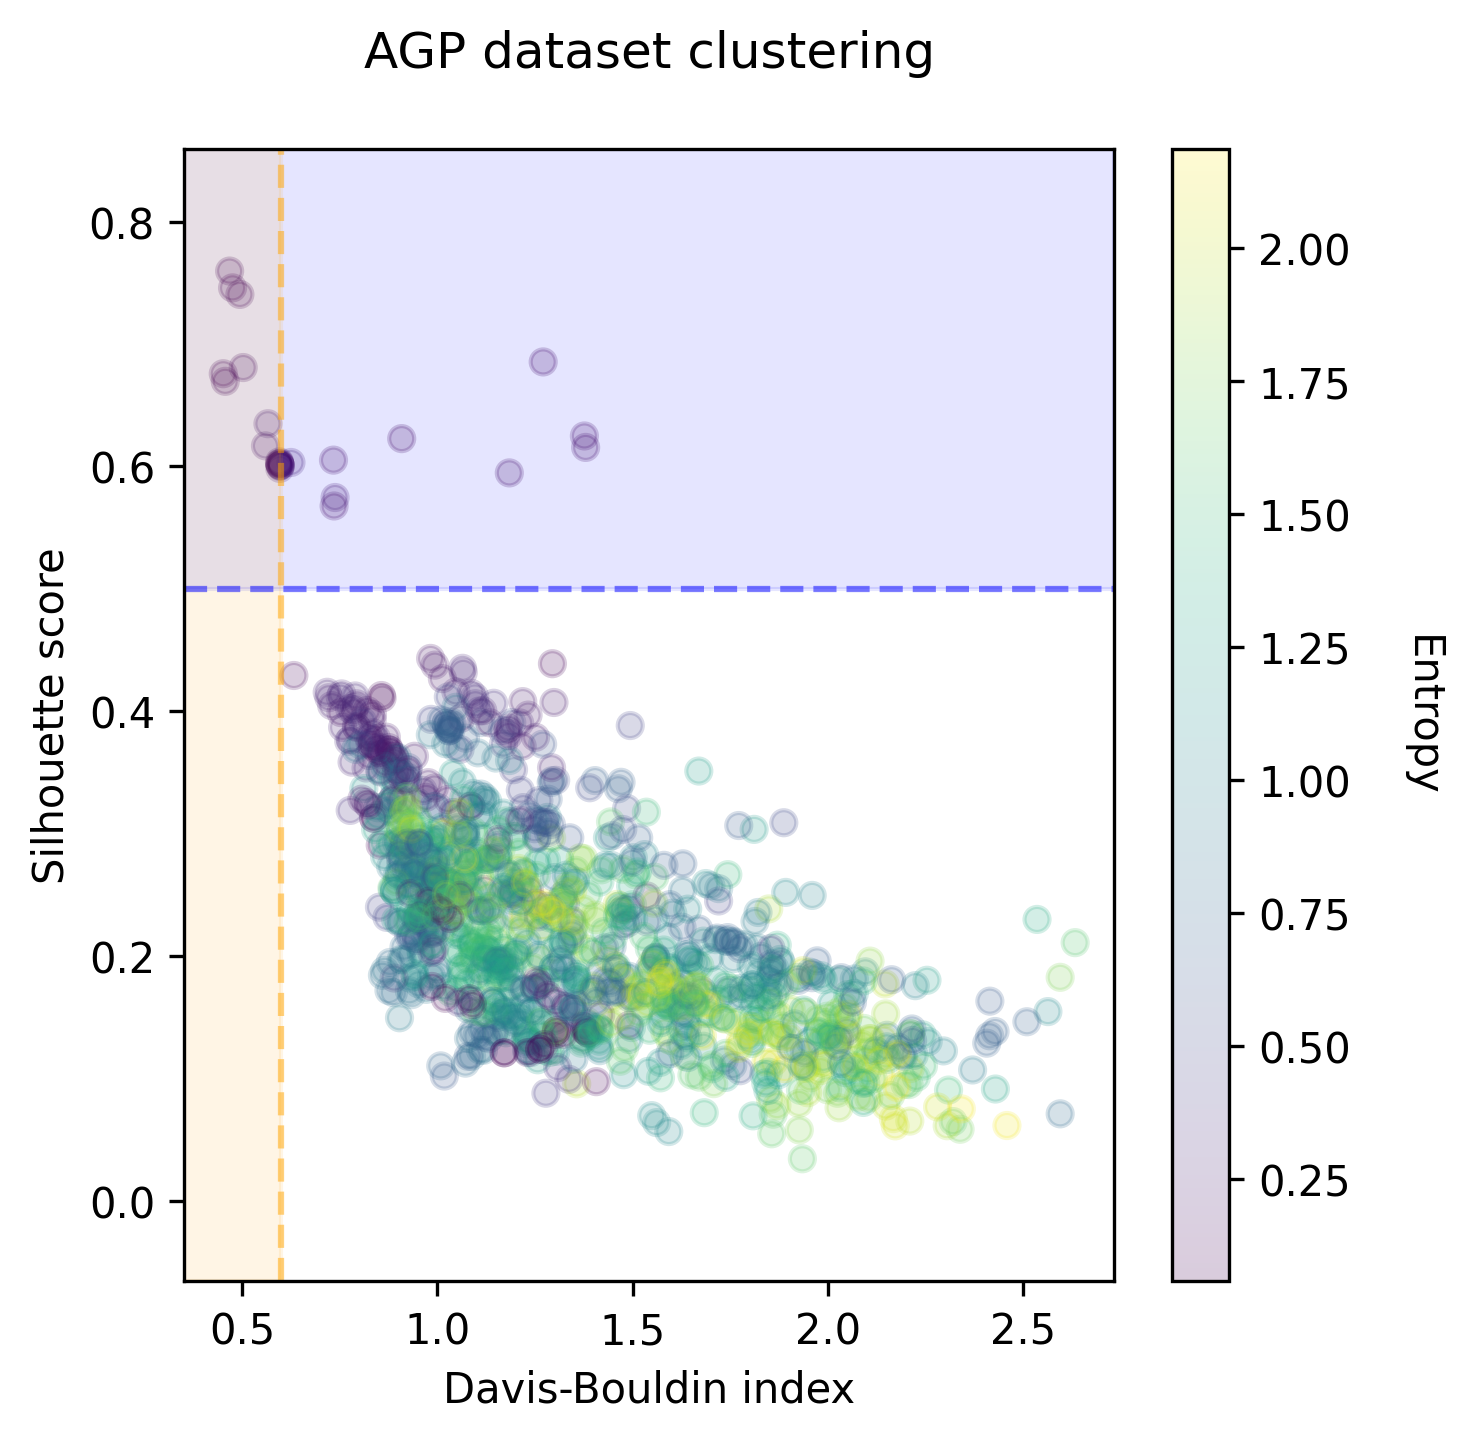

In [42]:
AGP_df = clustering_results_df_.query('dataset == "AGP"')

plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [43]:
selection_mask_AGP = (AGP_df['silh'] > SILHOUETTE_THRESH) * (AGP_df['dbind'] < DBIND_THRESHOLD)
AGP_df[selection_mask_AGP]

,mask,labels,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist,dataset,tax,representation,cl_method,n_cl
419,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.597913,0.600387,-0.633918,0.940953,0.0,0.061010,0.994322,"[0.9888971132494448, 0.011102886750555145]",AGP,o,L1,SpectralClustering,2
420,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.597501,0.601028,-0.633912,0.758729,0.0,0.061036,0.993797,"[0.9888912399492171, 0.011108760050782903]",AGP,o,L1,SpectralClustering,2
421,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.597501,0.601028,-0.633912,0.332755,0.0,0.061036,0.993797,"[0.9888912399492171, 0.011108760050782903]",AGP,o,L1,SpectralClustering,2
422,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.596772,0.602147,-0.633902,0.253535,0.0,0.061084,0.992850,"[0.9888806523350631, 0.01111934766493699]",AGP,o,L1,SpectralClustering,2
423,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.596530,0.602548,-0.633899,0.322619,0.0,0.061100,0.992535,"[0.9888771186440678, 0.011122881355932203]",AGP,o,L1,SpectralClustering,2
424,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.595767,0.603720,-0.633889,0.257937,0.0,0.061147,0.991589,"[0.9888665040822818, 0.011133495917718164]",AGP,o,L1,SpectralClustering,2
1335,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.456921,0.669531,-0.901654,0.713146,0.0,0.058751,1.000000,"[0.010602353489455901, 0.9893976465105441]",AGP,o,lle,SpectralClustering,2
1336,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.475692,0.745889,-0.819943,0.821911,0.0,0.058751,1.000000,"[0.9893976465105441, 0.010602353489455901]",AGP,o,lle,SpectralClustering,2
1337,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.494456,0.740521,-0.858963,0.935781,0.0,0.061378,1.000000,"[0.988815099615519, 0.01118490038448095]",AGP,o,lle,SpectralClustering,2
1339,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.451904,0.675751,-0.901635,0.564286,0.0,0.058965,0.995573,"[0.010649502633118783, 0.9893504973668812]",AGP,o,lle,SpectralClustering,2


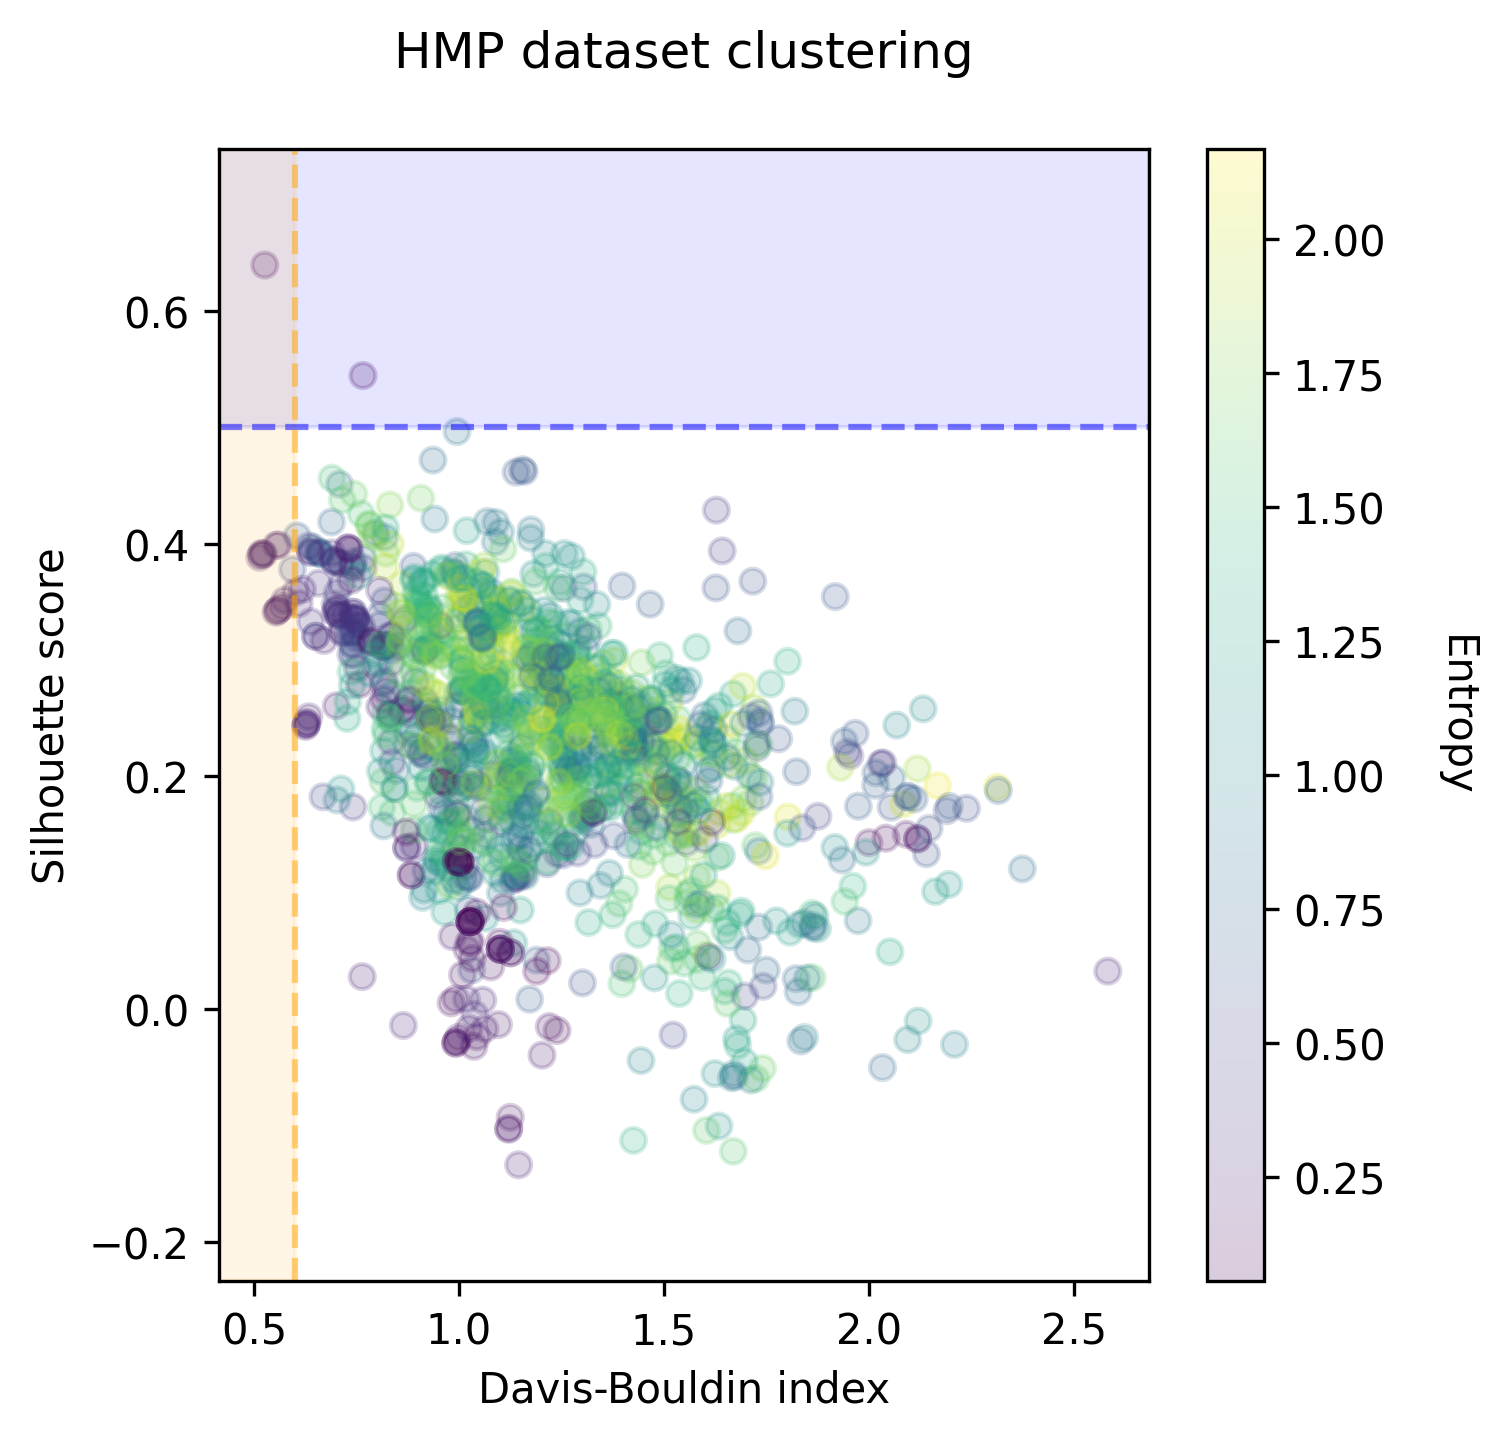

In [44]:
HMP_df = clustering_results_df_.query('dataset == "HMP"')
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [45]:
selection_mask_HMP = (HMP_df['silh'] > SILHOUETTE_THRESH) * (HMP_df['dbind'] < DBIND_THRESHOLD)
HMP_df[selection_mask_HMP]

,mask,labels,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist,dataset,tax,representation,cl_method,n_cl
1772,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.526218,0.639529,-0.629535,0.308863,0.0034,0.091247,0.9966,"[0.01827485380116959, 0.9817251461988304]",HMP,f,spectral,HDBSCAN,2


# DBVC and Prediction Strength, entropy coloring

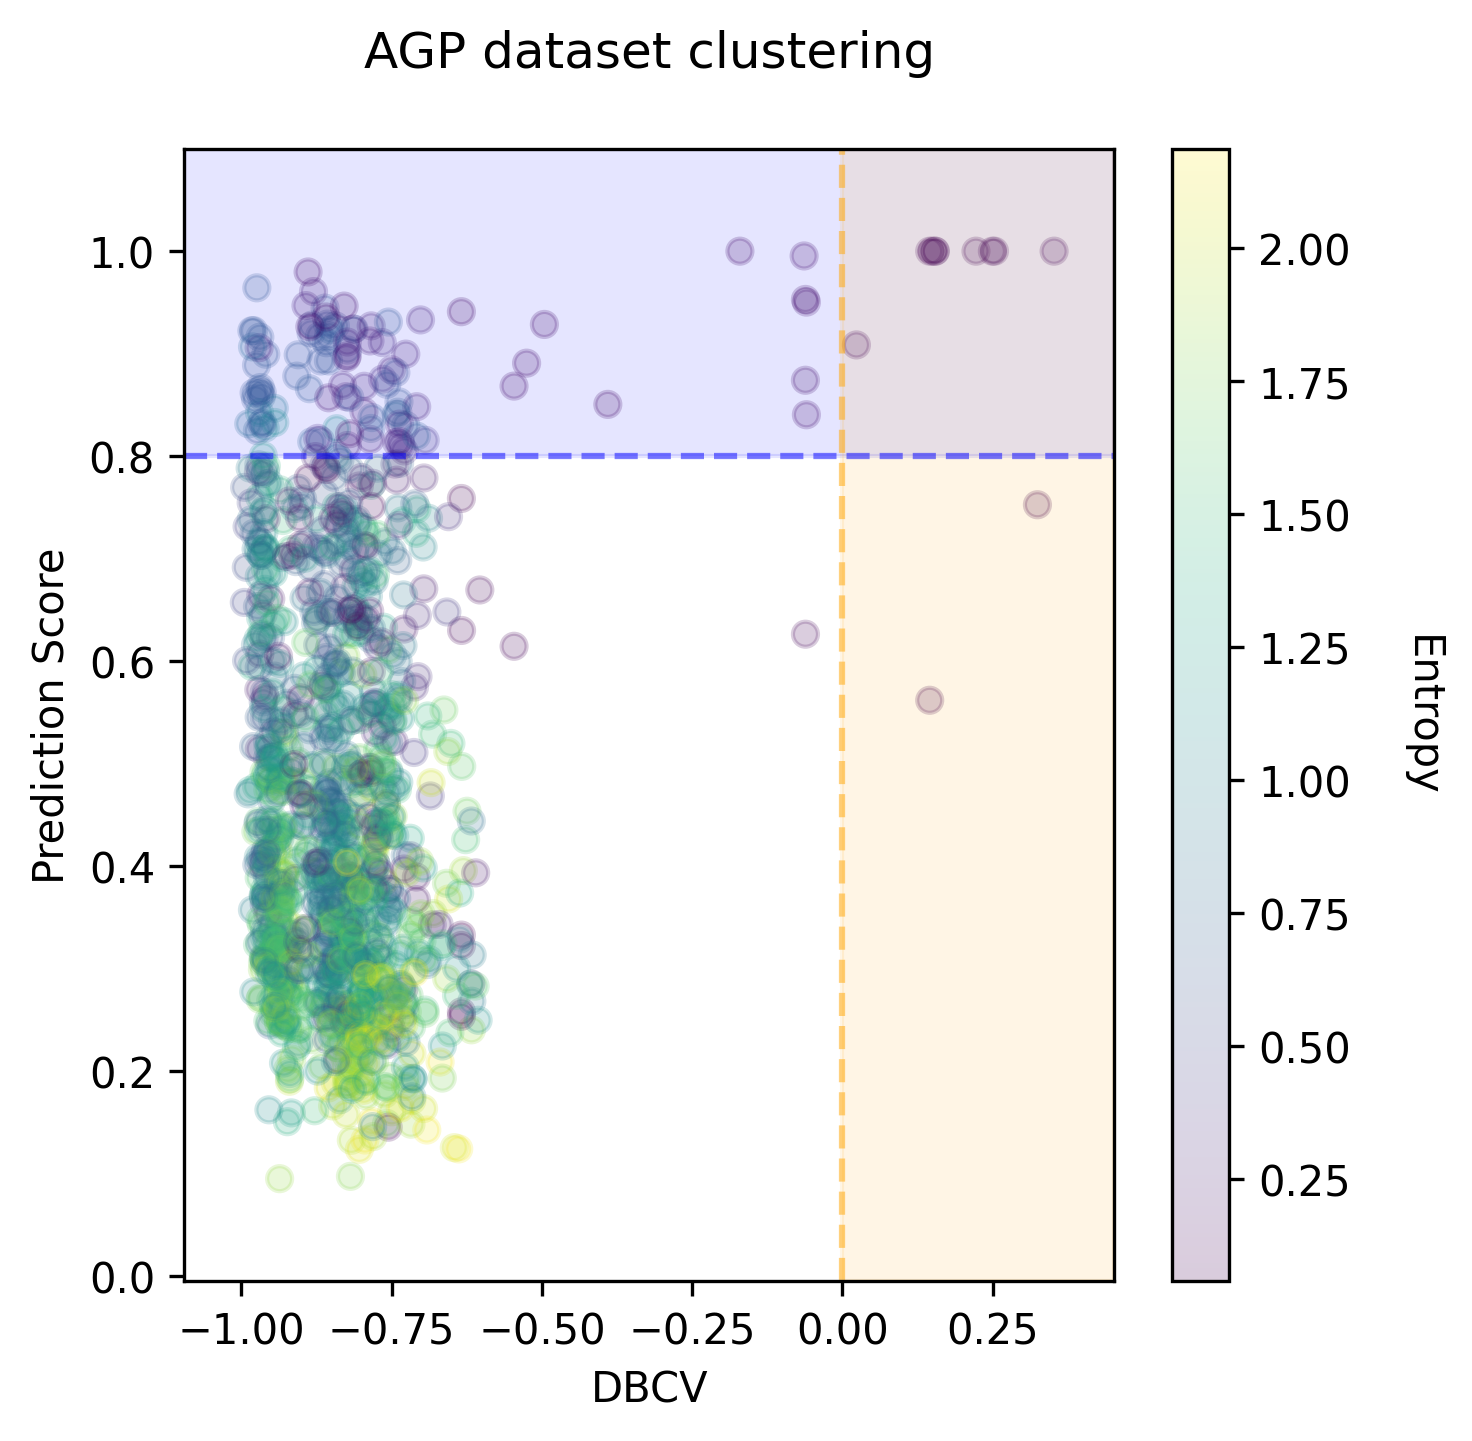

In [46]:
plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [47]:
selection_mask_AGP = (AGP_df['dbcv'] > DBCV_THRESHOLD) * (AGP_df['ps'] > PS_THRESHOLD)
AGP_df[selection_mask_AGP]

,mask,labels,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist,dataset,tax,representation,cl_method,n_cl
2099,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.302643,0.135913,0.023347,0.908537,0.020739,0.066122,0.979261,"[0.012254610350981559, 0.9877453896490185]",AGP,f,tsne,HDBSCAN,2
2100,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.305214,0.139166,0.145243,1.000000,0.024700,0.068946,0.975300,"[0.9870983156134273, 0.01290168438657269]",AGP,f,tsne,HDBSCAN,2
2101,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.381575,0.138722,0.154091,1.000000,0.005709,0.091267,0.994291,"[0.01827982188891493, 0.981720178111085]",AGP,f,tsne,HDBSCAN,2
2102,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.377895,0.139114,0.154748,1.000000,0.012000,0.091261,0.988000,"[0.018278301886792452, 0.9817216981132075]",AGP,f,tsne,HDBSCAN,2
2273,"[True, True, True, True, True, True, True, Tru...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.020210,0.165359,0.222267,1.000000,0.032506,0.064811,0.935454,"[0.9880433428820525, 0.01195665711794744]",AGP,f,umap,HDBSCAN,2
2415,"[True, True, True, True, True, True, True, Fal...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.032442,0.230711,0.253014,1.000000,0.010253,0.076598,0.983223,"[0.014693684085792155, 0.9853063159142078]",AGP,g,umap,HDBSCAN,2
2416,"[True, True, True, True, True, True, True, Fal...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.012828,0.236816,0.249530,1.000000,0.014331,0.075329,0.979494,"[0.014392767931485667, 0.9856072320685143]",AGP,g,umap,HDBSCAN,2
2417,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.000913,0.239300,0.149378,1.000000,0.019574,0.071064,0.974368,"[0.013392323328948942, 0.9866076766710511]",AGP,g,umap,HDBSCAN,2
2418,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.978277,0.244690,0.352238,1.000000,0.020273,0.067658,0.979727,"[0.012605541681531692, 0.9873944583184683]",AGP,g,umap,HDBSCAN,2


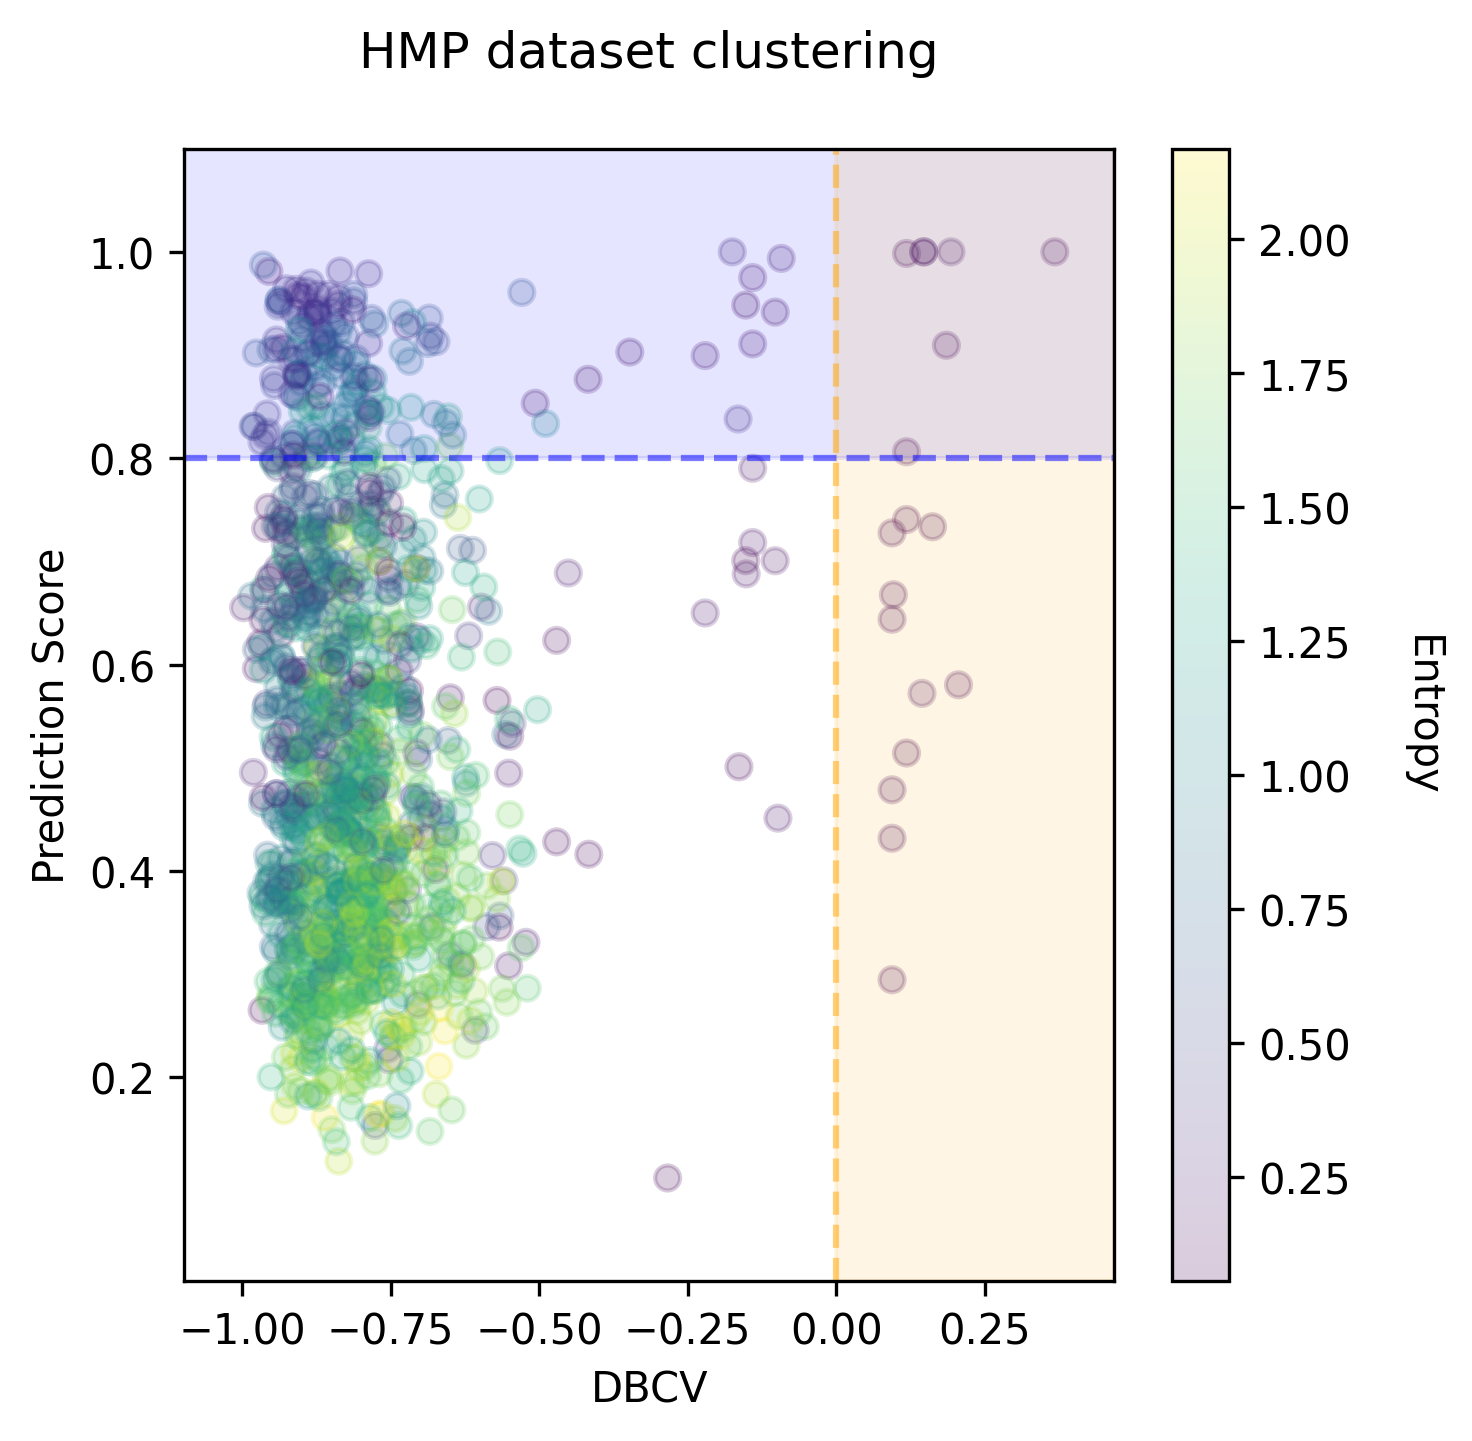

In [48]:
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [49]:
selection_mask_HMP = (HMP_df['dbcv'] > DBCV_THRESHOLD) * (HMP_df['ps'] > PS_THRESHOLD)
HMP_df[selection_mask_HMP]

,mask,labels,dbind,silh,dbcv,ps,noise_ratio,entropy,data_used,dist,dataset,tax,representation,cl_method,n_cl
2143,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.002359,0.126268,0.118507,0.806274,0.020180,0.057931,0.979820,"[0.010421836228287842, 0.9895781637717121]",HMP,o,tsne,HDBSCAN,2
2146,"[True, True, True, True, True, True, True, Tru...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.002359,0.126268,0.118507,0.998465,0.020180,0.057931,0.979820,"[0.010421836228287842, 0.9895781637717121]",HMP,o,tsne,HDBSCAN,2
2461,"[True, False, False, True, False, True, True, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.870812,0.152278,0.185611,0.909478,0.064187,0.078516,0.914661,"[0.9848484848484849, 0.015151515151515152]",HMP,o,umap,HDBSCAN,2
2462,"[True, True, True, True, True, True, True, Fal...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.099382,0.057483,0.368204,1.000000,0.072696,0.075587,0.908339,"[0.014453961456102784, 0.9855460385438972]",HMP,o,umap,HDBSCAN,2
2463,"[True, True, True, True, False, False, True, F...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.008875,0.029492,0.147603,1.000000,0.081935,0.138887,0.911014,"[0.9738457432612757, 0.010942087002935683, 0.0...",HMP,o,umap,HDBSCAN,3
2466,"[True, True, True, True, True, True, True, Fal...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.024671,0.057634,0.193421,1.000000,0.061755,0.157025,0.929006,"[0.015440984035592777, 0.9696414551164617, 0.0...",HMP,o,umap,HDBSCAN,3
2467,"[True, True, True, True, True, True, True, Fal...","[2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1.019468,0.051336,0.147477,1.000000,0.069779,0.151381,0.921955,"[0.014240506329113924, 0.014767932489451477, 0...",HMP,o,umap,HDBSCAN,3
